In [14]:
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from src.privacy_ml import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
from src.logistic_reg import cost

In [2]:
Nb_model = 10

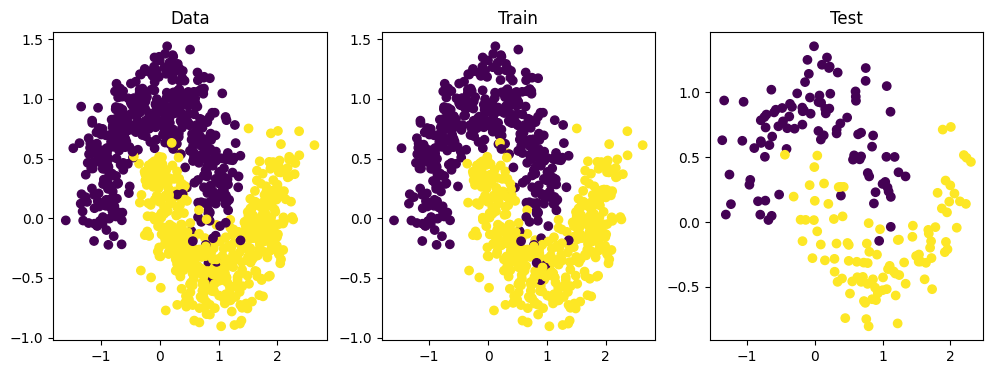

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

[ 65 166 175 191 308 354 605 751 761]


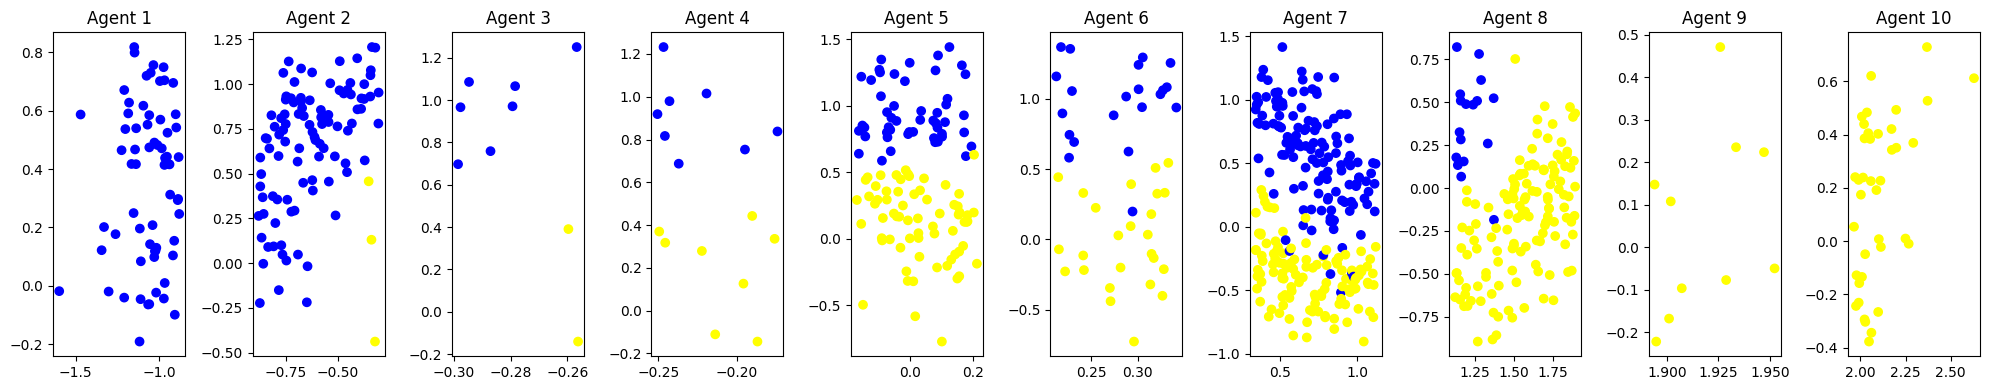

In [4]:

#X_agent, Y_agent = split_into_random_subsets(X_train, Y_train)
X_agent, Y_agent = split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=1, ncols=Nb_model, figsize=(20, 4))

for i in range(Nb_model):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(Nb_model):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [6]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)

In [7]:
G = np.zeros((Nb_model, Nb_model))
for i in range(Nb_model):
    for j in range(Nb_model):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(Nb_model)
c = np.zeros(Nb_model)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(Nb_model):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize



Max: 251
Min: 9
Mean: 80.0


supposons que l'on réveille d'abord les agents chacun leur tour.

In [8]:
T = 10000
mu = 0.05

## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf


Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $

## Training

In [9]:
thetas_mono = np.zeros(X_train.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = stepForwardMono(thetas_mono, X_train, Y_train)
    costs_train_mono[i] = cost(thetas_mono, X_train, Y_train)
    costs_test_mono[i] = cost(thetas_mono, X_test, Y_test)
    if i % 10 == 0:
                print(f'Iteration {i+1} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

Iteration 1 : Train: 0.4901 | Test: 0.4801
Iteration 11 : Train: 0.3264 | Test: 0.2895
Iteration 21 : Train: 0.3110 | Test: 0.2667
Iteration 31 : Train: 0.3068 | Test: 0.2590
Iteration 41 : Train: 0.3054 | Test: 0.2554
Iteration 51 : Train: 0.3048 | Test: 0.2536
Iteration 61 : Train: 0.3046 | Test: 0.2525
Iteration 71 : Train: 0.3045 | Test: 0.2518
Iteration 81 : Train: 0.3044 | Test: 0.2514
Iteration 91 : Train: 0.3044 | Test: 0.2511
Iteration 101 : Train: 0.3044 | Test: 0.2509
Iteration 111 : Train: 0.3044 | Test: 0.2508
Iteration 121 : Train: 0.3044 | Test: 0.2507
Iteration 131 : Train: 0.3044 | Test: 0.2507
Iteration 141 : Train: 0.3044 | Test: 0.2506
Iteration 151 : Train: 0.3044 | Test: 0.2506
Iteration 161 : Train: 0.3044 | Test: 0.2506
Iteration 171 : Train: 0.3044 | Test: 0.2506
Iteration 181 : Train: 0.3044 | Test: 0.2506
Iteration 191 : Train: 0.3044 | Test: 0.2505
Iteration 201 : Train: 0.3044 | Test: 0.2505
Iteration 211 : Train: 0.3044 | Test: 0.2505
Iteration 221 : Train

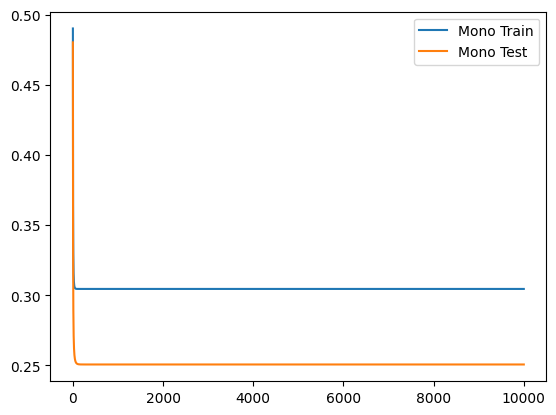

In [10]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

In [15]:
thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costs_train = np.zeros((T, Nb_model))
costs_test = np.zeros((T, Nb_model))


for i in range(T):
    thetas = stepForward(thetas, X_agent_augmented, Y_agent, Nb_model, mu, c, G, D)
    for j in range(Nb_model):
            costs_train[i,j] = cost(thetas[j], X_agent_augmented[j], Y_agent[j])
            costs_test[i,j] = cost(thetas[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : Train: {np.mean(costs_train[i]):.4f} and {np.std(costs_train[i]):.4f} | Test: {np.mean(costs_test[i]):.4f} and {np.std(costs_test[i]):.4f}')

Iteration 1 : Train: 0.4254 and 0.1721 | Test: 0.6570 and 0.0762
Iteration 1001 : Train: 0.2439 and 0.2394 | Test: 0.2735 and 0.0489
Iteration 2001 : Train: 0.2483 and 0.2532 | Test: 0.2151 and 0.0102
Iteration 3001 : Train: 0.2489 and 0.2583 | Test: 0.2025 and 0.0049
Iteration 4001 : Train: 0.2487 and 0.2613 | Test: 0.1978 and 0.0039
Iteration 5001 : Train: 0.2484 and 0.2634 | Test: 0.1954 and 0.0038
Iteration 6001 : Train: 0.2482 and 0.2652 | Test: 0.1940 and 0.0039
Iteration 7001 : Train: 0.2480 and 0.2666 | Test: 0.1929 and 0.0040
Iteration 8001 : Train: 0.2477 and 0.2678 | Test: 0.1921 and 0.0041
Iteration 9001 : Train: 0.2475 and 0.2689 | Test: 0.1915 and 0.0041


In [16]:
# Alternative : choix aléatoire des agents

thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_test = np.zeros(Nb_model)                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train = np.zeros(Nb_model)


# option 1 : randint avec quota global
import random as rd
tracking  = [0] * Nb_model # pour mesurer le nombre de fois que chaque agent passe

total_T = T*Nb_model

for i in range (total_T) :
    j = rd.randint(0, Nb_model-1)
    tracking[j] += 1

    thetas = stepForward_2(thetas, X_agent_augmented, Y_agent, j, Nb_model, mu, c, G, D) 

    costs_train[j] = (cost(thetas[j], X_agent_augmented[j], Y_agent[j]))
    costs_test[j] = (cost(thetas[j], X_test_augmented, Y_test))
        
    if i % (1000*Nb_model) == 0 :
        print(f'Iteration moyenne {1+i/Nb_model} : Train: {np.mean(costs_train):.4f} and {np.std(costs_train):.4f} | Test: {np.mean(costs_test):.4f} and {np.std(costs_test):.4f}')
       

Iteration moyenne 1.0 : Train: 0.0626 and 0.1878 | Test: 0.0652 and 0.1957
Iteration moyenne 1001.0 : Train: 0.2436 and 0.2384 | Test: 0.2824 and 0.0564
Iteration moyenne 2001.0 : Train: 0.2482 and 0.2524 | Test: 0.2180 and 0.0119
Iteration moyenne 3001.0 : Train: 0.2489 and 0.2579 | Test: 0.2036 and 0.0053
Iteration moyenne 4001.0 : Train: 0.2488 and 0.2608 | Test: 0.1985 and 0.0041
Iteration moyenne 5001.0 : Train: 0.2485 and 0.2630 | Test: 0.1959 and 0.0038
Iteration moyenne 6001.0 : Train: 0.2483 and 0.2647 | Test: 0.1943 and 0.0038
Iteration moyenne 7001.0 : Train: 0.2481 and 0.2662 | Test: 0.1932 and 0.0039
Iteration moyenne 8001.0 : Train: 0.2479 and 0.2675 | Test: 0.1924 and 0.0040
Iteration moyenne 9001.0 : Train: 0.2477 and 0.2685 | Test: 0.1918 and 0.0041


In [13]:
# option 2 : pondérer les agents

thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_test = np.zeros(Nb_model)                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train = np.zeros(Nb_model)

tracking  = np.zeros(Nb_model)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(Nb_model)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)

for i in range (T*Nb_model) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas = stepForward_2(thetas, X_agent_augmented, Y_agent, j, Nb_model, mu, c, G, D) # y'a probleme

    costs_train[j] = (cost(thetas[j], X_agent_augmented[j], Y_agent[j]))
    costs_test[j] = (cost(thetas[j], X_test_augmented, Y_test))
        
    if i % (1000*Nb_model) == 0 :
        print(f'Iteration moyenne {1+i/Nb_model} : Train: {np.mean(costs_train):.4f} and {np.std(costs_train):.4f} | Test: {np.mean(costs_test):.4f} and {np.std(costs_test):.4f}')
       

[0.08125 0.12625 0.01125 0.02    0.14625 0.0575  0.31375 0.1825  0.0125
 0.04875]
Iteration moyenne 1.0 : Train: 0.0684 and 0.2051 | Test: 0.0690 and 0.2069
Iteration moyenne 1001.0 : Train: 0.2421 and 0.2356 | Test: 0.2973 and 0.0675
Iteration moyenne 2001.0 : Train: 0.2474 and 0.2509 | Test: 0.2219 and 0.0145
Iteration moyenne 3001.0 : Train: 0.2487 and 0.2571 | Test: 0.2053 and 0.0061
Iteration moyenne 4001.0 : Train: 0.2488 and 0.2603 | Test: 0.1995 and 0.0043
Iteration moyenne 5001.0 : Train: 0.2487 and 0.2626 | Test: 0.1967 and 0.0039
Iteration moyenne 6001.0 : Train: 0.2484 and 0.2643 | Test: 0.1950 and 0.0038
Iteration moyenne 7001.0 : Train: 0.2483 and 0.2659 | Test: 0.1937 and 0.0039
Iteration moyenne 8001.0 : Train: 0.2481 and 0.2672 | Test: 0.1928 and 0.0040
Iteration moyenne 9001.0 : Train: 0.2479 and 0.2683 | Test: 0.1921 and 0.0040


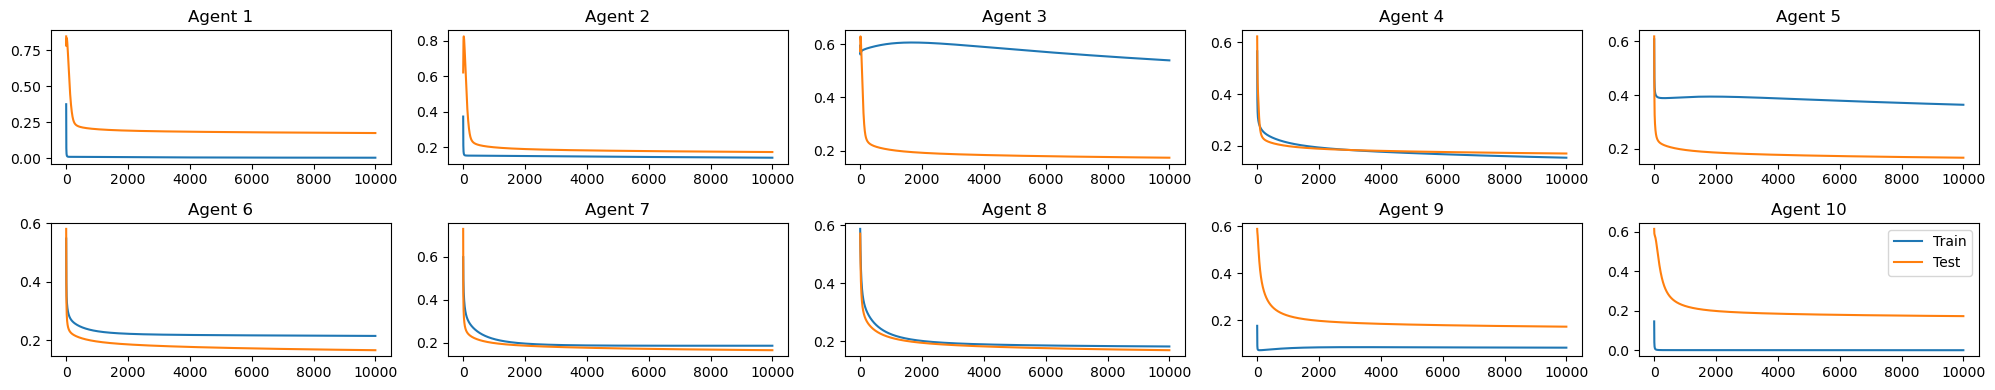

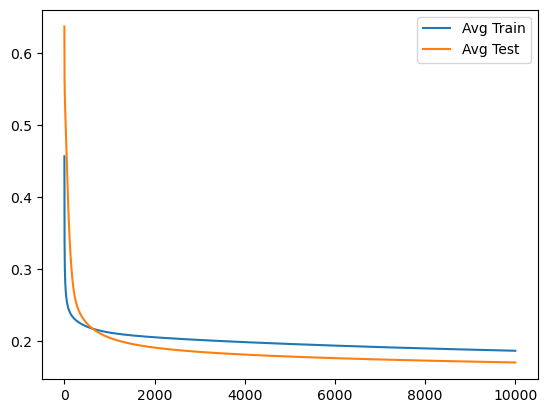

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=int(Nb_model/2), figsize=(20, 4))

for i in range(Nb_model):
    row = i // (Nb_model // 2)
    col = i % (Nb_model // 2)
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[row, col].plot(costs_train[:, i], label='Train')
    axes[row, col].plot(costs_test[:, i], label='Test')
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.legend()
plt.show()


plt.plot(np.mean(costs_train, axis=1), label="Avg Train")
plt.plot(np.mean(costs_test, axis=1), label="Avg Test")
plt.legend()
plt.show()